In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


- next meeting: 18, Monday 
- Kai's Job: 
    - X1.set missing to NaN 
    - X2. data cleansing- interpolation; moving average ; 
    - X3. sample class and function for each stage (outline)
    - X4. plots; 5. LSTM coding; 6. Adfuller iwth different IC;
    - X5. LSTM model construction (reframe)
    - X6. MAE/RMSE error evaluation
    -  7. Fine Tune framework
    -  8. How to train a model that accepts missing values?(https://machinelearningmastery.com/handle-missing-timesteps-sequence-prediction-problems-python/)
    -  9. look up fractional cointegration model. Adfuller test in function form?
    - 10. (VECM model)
    - 11. ...
    - PS2. other possible imputation methods: KNN, stochastic regression
    - 
- Bennet's Job:
    - X1. periodogram, imputation of linear regression
    - X2. Get familiar with pandas and functions
    - X3. ac/pac/auto-corr-residual plots.
    - PS. how to calculate rmse depnding on imputed values
    - PS2. data splitting ratio for train/validation/test: 8/1/1
    
    
- Together: 
    - 1. look up python package that help read R code inbody.
    - 2. VAR model (Rstudio/python)(adftest/ take differences/ cointegration check/ VAR_1stDiff|VAR_Ori|VECM model choice via (lag choice and coefs estimation)/ (adjusted-)portmanteau test /inference and performance.)

In [2]:
import os
for dirname, _, filenames, in os.walk('/Users/mbpr/GitHub/Acea-Smart-Water-Analytics/data/'):
    for filename in filenames: 
        print(os.path.join(dirname, filename))

/Users/mbpr/GitHub/Acea-Smart-Water-Analytics/data/Aquifer_Auser.csv
/Users/mbpr/GitHub/Acea-Smart-Water-Analytics/data/River_Arno.csv
/Users/mbpr/GitHub/Acea-Smart-Water-Analytics/data/Lake_Bilancino.csv
/Users/mbpr/GitHub/Acea-Smart-Water-Analytics/data/Aquifer_Petrignano.csv
/Users/mbpr/GitHub/Acea-Smart-Water-Analytics/data/~$dataset_description.xlsx
/Users/mbpr/GitHub/Acea-Smart-Water-Analytics/data/Aquifer_Doganella.csv
/Users/mbpr/GitHub/Acea-Smart-Water-Analytics/data/dataset_description.ods
/Users/mbpr/GitHub/Acea-Smart-Water-Analytics/data/dataset_description.xlsx
/Users/mbpr/GitHub/Acea-Smart-Water-Analytics/data/Water_Spring_Lupa.csv
/Users/mbpr/GitHub/Acea-Smart-Water-Analytics/data/Water_Spring_Madonna_di_Canneto.csv
/Users/mbpr/GitHub/Acea-Smart-Water-Analytics/data/Water_Spring_Amiata.csv
/Users/mbpr/GitHub/Acea-Smart-Water-Analytics/data/Aquifer_Luco.csv


In [3]:
import pandas as pd
import numpy as np
from datetime import datetime, date 
# from termcolor import colored
import math
import missingno as mnso
from functools import partial

In [4]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.axes._axes import _log as matplotlib_axes_logger
# matplotlib_axes_logger.setLevel('ERROR')

import tensorflow as tf
import keras
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.decomposition import PCA
# from sklearn.model_selection import cross_validate, StratifiedKFold

import statsmodels
import statsmodels.stats.stattools
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa import vector_ar
from statsmodels.tsa.api import VAR
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# Plotting Functions 

In [5]:
def aquifer_feature_plots(df):
    """Plot each group of features of aquifer dataframe"""
    date_flag = 0
    # create Date column
    if not 'Date' in df.columns.values:
        df['Date'] = df.index
        date_flag = 1
    # plot Rainfalls
    sns.relplot(x='Date', y='value', col='Feature', col_wrap=5, kind='line', 
                data = df.filter(regex='Date|^Rainfall_.+').melt(
                        id_vars='Date', var_name='Feature', ignore_index=False))
    plt.suptitle('Rainfalls', y=1.02)
    # plot gounrdwaters and Volumes
    sns.relplot(x='Date', y='value', hue='Feature', kind='line', 
                data = df.filter(regex='Date|^Depth_.+').melt(
                        id_vars='Date', var_name='Feature', ignore_index=False))
    plt.suptitle('Groundwaters', y=1.02)
    sns.relplot(x='Date', y='value', hue='Feature', kind='line', 
                data = df.filter(regex='Date|^Volume_.+').melt(
                        id_vars='Date', var_name='Feature', ignore_index=False))
    plt.suptitle('Volumes', y=1.02)
    # plot Temperatures
    sns.relplot(x='Date', y='value', col='Feature', kind='line', 
                data = df.filter(regex='Date|^Temperature.+').melt(
                        id_vars='Date', var_name='Feature', ignore_index=False))
    plt.suptitle('Temperatures', y=1.02)
    # plot Hydrometry
    sns.relplot(x='Date', y='value', col='Feature', kind='line', 
                data = df.filter(regex='Date|^Hydrometry_.+').melt(
                        id_vars='Date', var_name='Feature', ignore_index=False))
    plt.suptitle('Hydrometries', y=1.02)
    plt.show()
    if date_flag:
        df.drop(columns='Date', inplace=True)

def missingval_plot(df):
    """
    Visualize index location of missin values of each feature.
    Doesn't work for 1-dim df.
    """
    f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 6))
    g = sns.heatmap(df, cmap='Blues', cbar=True, yticklabels=df.index.values)
    # customize colorbar
    colorbar = g.collections[0].colorbar
    colorbar.set_ticks([0, 1])
    colorbar.set_ticklabels(['non-missing', 'missing'])
    # customize title
    ax.set_title('Distribution of Missing Values', fontsize=16)
    # customize font size in ticks
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(12) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(12)
    plt.show()

def corrtri_plot(df):
    """correlation plot of the dataframe"""
    # sns.set() #: will cause plt warning later in lag_plot
    c = df.corr()
    mask = np.triu(c.corr(), k=1)
    plt.figure(figsize=(10, 10))
    plt.tick_params(axis='both', which='major', labelsize=10, 
                    bottom=False, labelbottom=False, 
                    top=False, labeltop=True)
    g = sns.heatmap(c, annot=True, fmt='.1f', cmap='coolwarm', 
                    square=True, mask=mask, linewidths=1, cbar=False)
    plt.show()

# Start with an example, generalize later -> else messy
def periodogram(series, division=8):
    """plot periodogram of the series to find most important frequency/periodicity"""
    dt = 1
    T = len(series.index)
    t = np.arange(0, T, dt)
    f = series.fillna(0)
    n = len(t)
    fhat = np.fft.fft(f, n, )
    PSD = np.conj(fhat) / n
    freq = np.arange(n) # * (1/(dt*n))
    L = np.arange(1, np.floor(n/division), dtype="int") # n/4, otherwise too long of a stretch to see anything
    
    plt.plot(freq[L], np.real(PSD[L]), linewidth=2, label='Lag Importance')
    plt.xlim(freq[L[0]], freq[L[-1]])
    plt.legend()
    plt.hlines(0, xmin=0, xmax=n, colors='black')
    plt.title('Periodogram of ' + series.name)
    plt.show()
    
def rfft_plot(series, ylim=(0,400)):
    """plot real valued fourier transform to find most important frequency/periodicity"""
    fft = tf.signal.rfft(series)
    f_per_dataset = np.arange(0, len(fft))

    n_samples_d = len(series)
    d_per_year = 365.2524
    years_per_dataset = n_samples_d/(d_per_year)
    f_per_year = f_per_dataset/years_per_dataset

    plt.step(f_per_year, np.abs(fft))
    plt.xscale('log')
    plt.ylim(*ylim)
    plt.xlim([0.1, max(plt.xlim())])
    plt.xticks([1, 4, 12, 52, 365.2524], labels=['1/Year', '1/quarter', '1/month', '1/week', '1/day'])
    _ = plt.xlabel('Frequency (log scale)')
    plt.show()
    
def metrics_plot(valdict, testdict, metrics, verbose=False):
    x = np.arange(len(testdict))
    width=0.3

    fig, axs = plt.subplots(1, len(metrics), figsize=(10,5))
    for i, key in enumerate(metrics):
        val_performance = [valdict[model][key] for model in valdict.keys()]
        test_performance = [testdict[model][key] for model in testdict.keys()]
        
        axs[i].bar(x - 0.17, val_performance, width, label='Validation')
        axs[i].bar(x + 0.17, test_performance, width, label='Test')
        axs[i].set_xticks(np.arange(len(test_performance)))
        axs[i].set_xticklabels(list(testdict.keys()), rotation=90)
        axs[i].set(ylabel=key)
        _ = axs[i].legend()
    fig.tight_layout(pad=2)
        
    if verbose: 
        for name, value_dict in testdict.items():
            print(f'{name:16s}')
            for key, val in value_dict.items():
                if key not in metrics: continue
                print(f'  {key:<20s}: {val:6.4f}')
                
def lag_plot(df, lag=1, redcols=None):
    """
    plot t+lag against t of each feature in df.
    df: pd.dataframe
    redcols: list/array of column names to be colored with red.
    """
    plt.figure(figsize=(20,15))
    for i, col in enumerate(df.columns):
        ax = plt.subplot(len(df.columns)//5 +1 , 5, i+1)
        color = 'k'
        if redcols is not None and col in redcols:
            color = 'r'
        pd.plotting.lag_plot(df[col], lag=lag)
        plt.title(col, color=color)
    ax.figure.tight_layout(pad=0.5)
    
def acpac_plot(data):
    """Autocorrelation and Partial-aurocorrelation plots."""
    for i, col in enumerate(data.columns):
        fig, ax = plt.subplots(1,2,figsize=(10,5))
        plot_acf(data[col], lags=30, title='Autocorrelation: ' + data[col].name, 
                 ax=ax[0])  # missing='drop'
        plot_pacf(data[col], lags=30, title='Partial Autocorrelation: ' + data[col].name, 
                 ax=ax[1])
        plt.show()


# Data Preprocessing & Feature Engineering

In [6]:
def fillna(data, approach, **kwargs):
    """fill nan with the specified approach."""
    if approach == 'constant':
        return data.fillna(-99999)
    elif approach == 'mean':
        return data.fillna(data.mean(axis=0, skipna=True))
    elif approach == 'median':
        return data.fillna(data.median(axis=0, skipna=True))
    elif approach == 'interpolate':
        # data cannot contain datetime columns
        # kwargs: method, axis, limit, limit_direction, limit_area, inplace
        return data.interpolate(**kwargs)
    elif approach == 'movingavg':
        # kwargs: window, min_periods, center, win_type
        return data.fillna(data.rolling(**kwargs).mean())
    elif approach == 'regression':
        names = data.columns.drop('Date', errors='ignore')
        for t in range(0, data.shape[0]):
            for feature in names:
                if not np.isnan(data[feature].iloc[t, ]):
                    continue
                parameters = names.drop(feature)
                parameters = data[parameters].iloc[t, ].dropna(axis='columns').columns
                model = linear_model.LinearRegression()
                model.fit(X=data[parameters], y=data[feature])
                data[feature].iloc[t, ] = model.predict(data[parameters])[t]
        return data
    elif approach == 'stochasticreg':
        pass
    elif approach == 'KNN':
        pass
    elif approach == 'LDA':
        pass
    else:
        raise ValueError('Keyword not found for approach')

# PCA requires no missing values and components to be stationary.
def get_component_number(data, min_variance_share=0.8, leave_out_regex = "Depth.*"):
    """
    Return the number of components that first retrieve the desired share of variance 
    via Principle Component Analysis.
    Inputs: 
        data: pd.DataFrame 
        min_variance_share: desired described share of variance
        leave_out_regex: pattern of columns in data that ought to be ignored.
    """
    names = data.columns.drop('Date', errors='ignore').drop(data.filter(regex=leave_out_regex).columns)
    x = data.loc[:, names].values
    x = StandardScaler().fit_transform(x)
    explained_variance = 0
    n = 0
    while explained_variance < min_variance_share:
        n = n + 1
        pca = PCA(n_components=n)
        principalComponents = pca.fit_transform(x)
        explained_variance = pca.explained_variance_ratio_.sum()
    print('Share of decribed variance: ', explained_variance)
    print('Number of components: ', n)
    return n

# Buids you a new dataset with only the desired number of components. Inuputs:
def build_pca_data(data, component_number=5, leave_out_regex="Depth.*"):
    """
    Builds a new df with only the desired number of components via PCA.
    Inputs: 
        data: pd.DataFrame 
        component_number: desired number of components.
        leave_out_regex: pattern of columns in data that ought to be ignored.
    """
    names = data.columns.drop('Date', errors='ignore').drop(data.filter(regex=leave_out_regex).columns)
    target = data.filter(regex=leave_out_regex).columns
    x = data.loc[:, names].values
    y = data.loc[:, target].values
    x = StandardScaler().fit_transform(x)
    pca = PCA(n_components=component_number)
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(data=principalComponents)  # , columns=['PC1', 'PC2', 'PC3'])
    finalDf = pd.concat([principalDf, df[target]], axis=1)
    return finalDf

def percent_change(values):
    """
    Calculate the %change between the last value and the mean of previous values.
    Makes data more comparable if the abs values of the data change a lot.
    Usage: df.rolling(window=20).aggregate(percent_change)
    """
    previous_values = values[:-1]
    last_value = values[-1]
    return (last_value - np.mean(previous_values)) / np.mean(previous_values)

def replace_outliers(series):
    # de-mean
    absolute_differences_from_mean = np.abs(series - np.mean(series))
    # identify >3 standard deviations from zero
    this_mask = absolute_differences_from_mean > (np.std(series) * 3)
    # Replace these values with the median accross the data
    series[this_mask] = np.nanmedian(series)
    return series
    
def scale(train, val, test, approach='MinMax'):
    """scale train (and test) data via MinMaxScalar/StandardScalar"""
    if approach == 'MinMax':
        scaler = MinMaxScaler(feature_range=(-1, 1))
    elif approach == 'Standard':
        scaler = StandardScaler()
    # save DataFrame Info
    # fit and transform train
    scaler = scaler.fit(train)
    train_scaled = pd.DataFrame(scaler.transform(train), columns=train.columns, index=train.index)
    # transform val/test
    val_scaled = pd.DataFrame(scaler.transform(val), columns=val.columns, index=val.index)
    test_scaled = pd.DataFrame(scaler.transform(test), columns=test.columns, index=test.index)
    return scaler, train_scaled, val_scaled, test_scaled

# primary function: used by following self-defined classes
def inverse_scale(scaler, data):
    """
    Applies to both single and multi-timestep predictions.
    data: 3d nparray (batch, timestep, n_out)
    """
    batch_size, timestep, n_out = data.shape[0], data.shape[1], data.shape[2]
    if 'MinMaxScaler' in str(type(scaler)):
        return ((data.reshape(-1, n_out) - scaler.min_[-n_out:]) / scaler.scale_[-n_out:]
               ).reshape(batch_size, timestep, n_out)
    elif 'StandardScaler' in str(type(scaler)):
        return (data.reshape(-1, n_out) * scaler.scale_ + scaler.mean_
               ).reshape(batch_size, timestep, n_out)

# primary function: used by following self-defined classes
def inverse_diff(history, pred, start=1):
    """
    Recover corresponding value of prediction in differenced feature back to the one before diff().
    Applies to both single and multi-timestep predictions of a single feature.
    Inputes: 
        history: 1d array/series of the feature.
        pred: 2d nparray (batch, timestep) corresponding to the feature, or 
              1d nparray (collection of 1-step-ahead predictions) corresponding to the feature.
        start: the starting position in history to add on values to pred.
               Usually start = pred[0]'s index -1 since pred is based on previous obersvation 
               due to diff().
    Return: 
        nparray with same shape as pred.
    """
    if type(history) is pd.Series:
        history = history.values
    if pred.ndim == 2:
        batch_size, timestep = pred.shape[0], pred.shape[1]
        return pred.cumsum(axis=1) + \
            history[start:start+batch_size].repeat(timestep).reshape(batch_size, timestep)
    if pred.ndim == 1: 
        # only supports 1-step-ahead model calculation.
        # -1: becuase last prediction is based on the previous obs, 
        # and there's no prediction based on history[-1].
        return pred + history[start:-1]

# Testing Functions

In [7]:
def adftest(series, verbose=True, **kwargs):
    """adfuller + printing"""
    # kwargs: maxlag, regression, autolag
    from statsmodels.tsa.stattools import adfuller
    res = adfuller(series.values, **kwargs)
    if verbose:
        print('ADF Statistic: {:13f} \tp-value: {:10f}'.format(res[0], res[1]))
        if 'autolag' in kwargs.keys():
            print('IC: {:6s} \t\t\tbest_lag: {:9d}'.format(kwargs['autolag'], res[2]))
        print('Critical Values: ', end='')
        for key, value in res[4].items():
            print('{:2s}: {:>7.3f}\t'.format(key, value), end='')
    return res

def adfuller_table(df, verbose=False, alpha=0.05, **kwargs):
    """iterate over adftest() to generate a table"""
    columns = [f'AIC_{int(alpha*100)}%level', 'AIC_bestlag', f'BIC_{int(alpha*100)}%level', 'BIC_bestlag']
    table = pd.DataFrame(columns=columns)
    for col in df.columns: 
        row = []
        for autolag in ['AIC', 'BIC']:
            res = adftest(df[col], verbose=verbose, autolag=autolag, **kwargs)
            sig = True if abs(res[0])>abs(res[4][f'{int(alpha*100)}%']) else False
            row.extend([sig, res[2]])
        table = table.append(pd.Series(row, index=table.columns, name=col))
    return table

def grangers_causation_table(data, xnames, ynames, maxlag, test='ssr_chi2test', alpha=None):
    """
    Check Granger Causality of all possible combinations of the Time series.
    The values in the table are the P-Values/boolean (reject H0 or not). 
    H0: X does not cause Y (iff coefs of X on Y is 0)
    Inputs:
        data      : pandas dataframe containing the time series variables
        xnames    : list of TS variable names to test granger causality on ynames.
        ynames    : list of TS variable names to be granger predicted.
        maxlag    : max lags.
        test      : 'ssr_ftest', 'ssr_chi2test', 'lrtest', 'params_ftest'
        alpha     : significance level. Return boolean table if alpha is specified != None.
    """
    res = pd.DataFrame(np.zeros((len(xnames), len(ynames))), columns=ynames, index=xnames)
    for c in res.columns:
        for r in res.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [ round(test_result[i+1][0][test][1],4) for i in range(maxlag) ]
            min_p_value = np.min(p_values)
            res.loc[r, c] = min_p_value
    res.columns = res.columns + '_y'
    res.index =  res.index + '_x'
    if alpha is None: 
        return df
    return res < alpha

def cointegration_test(df, det_order, diff_lag, alpha=0.05): 
    """
    Perform Johanson's Cointegration Test and Report Summary.
    Works at most 12 variables.
    Inputs (some):
        det_order : int
            * -1 - no deterministic terms
            * 0 - constant term
            * 1 - linear trend
        diff_lag : int, nonnegative
            Number of lagged differences in the model.
    """
    out = vector_ar.vecm.coint_johansen(df, det_order, diff_lag)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    # Summary
    print(' Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*25)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print('{:32s} :: {:>6.2f}  >  {:>8.4f} => {!s:>6}'.format(col, trace, cvt, trace>cvt) )

# Model Classes- Machine Learning

In [8]:
class WindowGenerator:
    """
    Initialize a window generator that helps slice train/val/test_df into inputs and labels
    that is suitable for supervised learning of machine learning approaches.
    
    Explanation for input_width, label_width, shift and total_window_size:
        Given inputs of size (batch, input_width, features), we wish to train a model that 
        its output shape is equivalent to the labels shape (batch, labels_width, features)
        which has a timestep gap = shift. total_window_size = input_width+shift.
    Eg, w=WindowGenerator(input_width=2, label_width=1, shift=1, ...)
        Given past 2 hrs, predict the target values in the next hr. (total window is 3)
    Eg, w=WindowGenerator(input_width=2, label_width=1, shift=2, ...)
        Given past 2 hrs, predict the result values in the 2nd hr. (total window is 4)
    Eg, w=WindowGenerator(input_width=2, label_width=2, shift=2, ...)
        Given past 2 hrs, predict the result values in next 2 hrs. (total window is 4)
    """
    
    def __init__(self, input_width, label_width, shift,
                 train_df, val_df, test_df, batch_size=1, shuffle=True, label_columns=None):
        assert input_width >= label_width, "Restriction input_width >= label_width breaks."
        # Store the raw data. [batch_size, timestep, features]
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.batch_size = batch_size
        self.shuffle = shuffle # make_dataset

        # Work out the label column indices.
        self.label_columns = [label_columns] if type(label_columns) is str else label_columns
        if self.label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(self.label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width) #slice from idx=0 till idx=input_width-1(included)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None) # slice from idx=label_start wihout end
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
        
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

    def split_window(self, features):
        """
        Split data into inputs and labels.
        features: [batch=None, self.total_window_size, features=None]
        """
        inputs = features[:, self.input_slice, :]
        # return all features if self.label_columns is None
        # Ow, return only featrues in self.label_columns in order
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)
        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels
    
    # Note: back-scaled outputs.reshape(-1,n_out) == \
    # dfimputed[targets][len(window.train_df)+window.label_indices[0]+1:int(0.9*N)+1]
    def inverse_transform_evaluate(self, scaler, model, diff, history, mode='test', 
                                   multioutput='uniform_average', return_dict=False):
        assert mode in ['val', 'test'], f'not allowed input: mode={mode}'
        # default test mode
        pred = model.predict(self.test)
        outputs = self.y_test
        start = len(self.train_df)+len(self.val_df)+self.label_indices[0]
        if mode == 'val':
            pred = model.predict(self.val)
            outputs = self.y_val
            start = len(self.train_df)+self.label_indices[0]
        # invert scale
        pred = inverse_scale(scaler, pred)
        outputs = inverse_scale(scaler, outputs)
        # invert diff
        for i, col in enumerate(self.label_columns):
            if col not in diff: 
                continue
            pred[:,:,i] = inverse_diff(history[col], pred[:,:,i], start)
            outputs[:,:,i] = inverse_diff(history[col], outputs[:,:,i], start )
        # metrics
        n_out = len(self.label_columns_indices)
        rmse = mean_squared_error(outputs.reshape(-1, n_out), pred.reshape(-1, n_out), 
                                 multioutput=multioutput, squared=False)
        mae = mean_absolute_error(outputs.reshape(-1, n_out), pred.reshape(-1, n_out), 
                                  multioutput=multioutput)
        if return_dict:
            return {'mean_absolute_error': mae, 'root_mean_squared_error': rmse}
        return mae, rmse

    def plot(self, plot_col, model=None, max_subplots=3, figsize=(15, 10)):
        inputs, labels = self.example # [batch_size, timestep, features]
        plt.figure(figsize=figsize, )
        if type(plot_col) is str: 
            plot_col = [plot_col]
        plot_col_index = [self.column_indices[col] for col in plot_col]
        
        max_n = min(max_subplots, len(inputs)) # arg vs batch_size
        max_j = len(plot_col)
        for n in range(max_n):
            for j in range(max_j):
                fig = plt.subplot(max_n, max_j, max_j*n + j+1)
                fig.figure.tight_layout(pad=1.0)
                # plot plot_col[j] as Inputs
                plt.title(f'y:{plot_col[j]} [scaled]')
                plt.plot(self.input_indices, inputs[n, :, plot_col_index[j]],
                         label='Inputs', marker='.', zorder=-10)
                # plot Ground truth of plot_col[j] == labels[label_col_index] (same string)
                if self.label_columns:
                    label_col_index = self.label_columns_indices.get(plot_col[j], None)
                else:
                    label_col_index = plot_col_index[j]
                if label_col_index is None:
                    continue
                plt.scatter(self.label_indices, labels[n, :, label_col_index], 
                            edgecolors='k', label='Labels', c='#2ca02c', s=64)
                # plot prediction of plot_col[j]
                if model is not None:
                    predictions = model(inputs)
                    plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                              marker='X', edgecolors='k', label='Predictions', c='#ff7f0e', s=64)
                if n == 0:
                    plt.legend()
                plt.xlabel(f'Sample {n} in batch.  Timestep [scaled]')

    def make_dataset(self, data):
        """convert df/data to timeseries dataset format of (inputs, labels) pairs"""
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
          data=data,
          targets=None,
          sequence_length=self.total_window_size,
          sequence_stride=1,
          shuffle=self.shuffle, # to be confirmed
          batch_size=self.batch_size,)
        # apply split window
        ds = ds.map(self.split_window)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result
    
    @property
    def y_val(self):    
        return np.array( list(self.val.map(lambda x,y: y).as_numpy_iterator())
                ).reshape(-1, self.label_width, len(self.label_columns_indices) )
    
    @property
    def y_test(self):
        return np.array( list(self.test.map(lambda x,y: y).as_numpy_iterator())
                ).reshape(-1, self.label_width, len(self.label_columns_indices) )

class Baseline(tf.keras.Model):
    """Single-step naive baseline: y(t+1) = y(t)"""
    def __init__(self, label_index=None, return_sequence=False):
        super().__init__()
        self.label_index = [label_index] if type(label_index) is int else label_index
        self.return_sequence = return_sequence

    def call(self, inputs):
        if self.label_index is None:
            return inputs

        if self.return_sequence:
            result = tf.stack( [inputs[:, :, j] for j in self.label_index] ,  axis=2)
            return result
        else: 
            result = tf.stack( [inputs[:, -1, j] for j in self.label_index] ,  axis=1)
            return result[:, tf.newaxis, :]

def compile_and_fit(model, window, max_epochs=30, patience=2, verbose=2):
    """
    Compile the given model and fit it via given window. 
    
    Inputs: 
        model: self-defined machine learning model
        window: object defined by class WindowGenerator()
        max_epochs: desired maximum epochs when fitting model to training data
        patience: Stop fitting if val_loss doesn't decrease for n=patience epochs.
        verbose: show training progress in different ways if 1 or 2. Turn off if 0.
    """
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanAbsoluteError(), tf.metrics.MeanSquaredError()])

    history = model.fit(window.train, epochs=max_epochs,
                        validation_data=window.val,
                        callbacks=[early_stopping], verbose=verbose)
    return history


# Model Classes- VAR

In [9]:
# TODO: 3 Possible models: VECM model | VAR_original model | VAR_stationary model
class VARresults:
    def __init__(self, obj, test, mask=None, label_columns=None):
        assert 'VARResultsWrapper' in str(type(obj))
        self.model = obj
        self.test = test
        self.column_indices = {name: i for i, name in enumerate(test.columns)}
        
        self.label_columns = test.columns
        if label_columns is not None:
            self.label_columns = [label_columns] if type(label_columns) is str else label_columns
        self.label_columns_indices = {name: i for i, name in
                                      enumerate(self.label_columns)}
        
        self.gt = self.test[self.label_columns].values[self.model.k_ar:]
        self.mask = mask 
        if mask is not None: 
            assert mask.shape[0] == self.test.shape[0]
            self.mask = mask[self.label_columns].values[self.model.k_ar:]
        
    def durbin_watson_test(self):
        res = statsmodels.stats.stattools.durbin_watson(self.model.resid)
        for col, value in zip(train.columns, res):
            print( '{:32s}: {:>8.4f}'.format(col, value))
    
    def residac_plot(self, cols=None, figsize=(16, 8), ylim=(-.3, .3)):
        plt.figure(figsize=figsize)
        # case pd.Series
        if self.model.resid.ndim ==1:
            ax = pd.plotting.autocorrelation_plot(self.model.resid)
            ax.set(ylim=ylim)
            plt.title(f'Residual Autocorrelation: {resid.name}')
            plt.show()

        # case pd.DataFrame         
        assert cols is not None, "cols is required since model dimension > 1."
        if type(cols) is str: cols = [cols]
        for count, (name, series) in enumerate(self.model.resid[cols].iteritems()):
            ax = plt.subplot( len(cols)//3 +1, 3, count+1)
            ax.figure.tight_layout(pad=0.5)
            ax.set(ylim=ylim)
            pd.plotting.autocorrelation_plot(series, ax=ax)
            plt.title(f'Residual Autocorrelation: {name}')
        plt.show()
    
    def predict(self, steps=1, mode='normal', inplace=False):
        """
        steps: n-steps-ahead prediction if steps=n.
        mode: 'normal': predict for each sample.
              'last': only predict the last sample. 
                      Eg, predict 14 days in a row from last sample.
        Return if inplace=False: 2D-array (predictions, features).
        """
        assert mode in ['normal', 'last'], 'Error: mode value not allowed'
        varlag = self.model.k_ar
        targets_indices = [self.column_indices[ta] for ta in self.label_columns]
        pred = []
        
        if mode == 'normal':
            pred_collector = []
            for s in range(test.shape[0] -varlag +1 -steps):
                pred = self.model.forecast(y=self.test.values[s:s+varlag], steps=steps)
                pred_collector.append(pred)
            pred = np.stack(pred_collector)[:, :, targets_indices]
            if pred.shape[1] == 1:
                pred = pred.reshape(-1, len(targets_indices))
        elif mode == 'last':
            s = -steps -varlag
            pred = self.model.forecast(y=self.test.values[s:s+varlag], steps=steps)
            pred = pred[:, targets_indices]
        if inplace: 
            self.mode = mode
            self.steps = steps
            self.pred = pred
            return ;
        return pred
        
    def inverse_transform(self, diff, history, start=None, inplace=False):
        """
        Inverse transform in-built pred and test on features in the diff list 
        based on history and start and the mode you use in predict() function.
        Applies to both 3D or 2D arrays.
        Return: pred, gt if inplace=False
        """
        varlag = self.model.k_ar
        pred = self.pred.copy()
        gt = self.gt.copy()
        if start is None: 
            start = -gt.shape[0] -1
            
        for i, col in enumerate(self.label_columns):
            if col not in diff: 
                continue
            if pred.ndim == 2:
                if self.mode == 'normal':
                    pred[:,i] = inverse_diff(history[col], pred[:,i], start=start)
                elif self.mode == 'last':
                    # -1: based on previous day
                    pred[:,i] = pred[:,i].cumsum() + history[col][-self.steps-1] 
            elif pred.ndim ==3:
                pred[:,:,i] = inverse_diff(history[col], pred[:,:,i], start=start)
            gt[:,i] = inverse_diff(history[col], gt[:,i], start=start)

        if inplace:
            self.pred = pred
            self.gt = gt
            return ;
        return pred, gt
    
    def evaluate(self, y_true=None, y_pred=None, multioutput='uniform_average', use_mask=True):
        """
        Calculate rmse and mae. 
        mode: can be ['raw_values', 'uniform_average'].
        mask: mask prediction and groudtruth when calculating performance.
              should be the same shape as groundtruth.
        """
        # only works for steps=1 case
        mask = self.mask.copy()
        if y_true is None:
            y_true = self.gt
        if y_pred is None: 
            y_pred = self.pred
        if self.mode == 'last':
            y_true = y_true[-self.steps:]
            mask = mask[-self.steps:]
            
        if use_mask: 
            rmse, mae = [], []
            for j in range(len(self.label_columns)):
                rmsee = mean_squared_error(y_true[~mask[:,j], j], y_pred[~mask[:,j], j], squared=False)
                maee = mean_absolute_error(y_true[~mask[:,j], j], y_pred[~mask[:,j], j])
                rmse.append(rmsee)
                mae.append(maee)
            rmse = np.array(rmse)
            mae = np.array(mae)
            if multioutput == 'uniform_average':
                rmse = rmse.mean()
                mae = mae.mean()
        else:
            rmse = mean_squared_error(y_true, y_pred, multioutput=multioutput, squared=False)
            mae = mean_absolute_error(y_true, y_pred, multioutput=multioutput)
        
        return mae, rmse
    
    def inverse_transform_evaluate(self, diff, history, start=None, steps=1, 
                                   mode='normal', multioutput='uniform_average', use_mask=False):
        """
        do predict(), inverse_transform(), and evaluate() all at once, but with 
        inplace=True setting, which is fixed and not adjustable.
        """
        inplace = True
        if inplace:
            self.predict(steps, mode, inplace=inplace)
            self.gt = self.test[self.label_columns].values[self.model.k_ar:]
            self.inverse_transform(diff, history, start, inplace=inplace)
        return self.evaluate(multioutput=multioutput, use_mask=use_mask)
        
    def plot(self, figsize=(20,15), use_mask=False):
        """plot prediction and groundtruth"""
        mae, rmse = self.evaluate(multioutput='raw_values', use_mask=use_mask)
        mask = self.mask.copy()
            
        plt.figure(figsize=figsize)
        if self.mode == 'normal':
            for j in range(len(self.label_columns)):
                ax = plt.subplot(len(self.label_columns), 1, j+1)
                dates = test[self.label_columns[j]].index[self.model.k_ar:]
                # prediction
                ax.plot(dates, self.pred[:,j],
                        c='red', linestyle='-', alpha=0.5, marker='+', label='prediction')
                # groundtruth: apply mask if provided
                if use_mask: 
                    ax.scatter(dates[~mask[:,j]], self.gt[~mask[:,j], j], 
                               c='k', linestyle='-', alpha=0.7, marker='+', label='groundtruth')
                else: 
                    ax.scatter(dates, self.gt[:, j], 
                               c='k', linestyle='-', alpha=0.7, marker='+', label='groundtruth')
                # title and x/y-labels
                ax.set(title='{:>32s}: RMSE={:6.4f}, MAE={:6.4f}'.format(targets[j], rmse[j], mae[j]), 
                       ylabel='meters')
                plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%y-%b'))
                ax.legend()
            ax.figure.tight_layout(pad=1)
            plt.show()
            
        elif self.mode == 'last':
            for j in range(len(targets)):
                ax = plt.subplot(len(self.label_columns), 1, j+1)
                dates = test[self.label_columns[j]].index[self.model.k_ar:]
                # prediction 
                ax.plot(dates[-self.steps:], self.pred[:,j],
                           c='r', linestyle='-', alpha=0.5, marker='+', label='pred')
                # groundtruth
                if use_mask: 
                    ax.scatter(dates[~mask[:,j]], self.gt[~mask[:,j], j], 
                               c='k', linestyle='-', alpha=0.7, marker='+', label='groundtruth')
                else: 
                    ax.scatter(dates, self.gt[:, j], 
                               c='k', linestyle='-', alpha=0.7, marker='+', label='groundtruth')
                # title and x/y-labels
                ax.set(title='{:>32s}: RMSE={:6.4f}, MAE={:6.4f}'.format(targets[j], rmse[j], mae[j]), 
                       ylabel='meters')
                plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%y-%b'))
                ax.legend()
            ax.figure.tight_layout(pad=1)
            plt.show()
        


# Main Code

## Aquifer: Auser
There are 5 different kinds of Depth_to_Groundwater_* variables, where SAL, PAG, CoS, DIEC stand for north systems and LT2 stands for south system. (south system is partially affected by the north ones).
The goal is to predict SAL, COS, and LT2.

In [10]:
dataset = 'Aquifer_Auser.csv'
targets = ['Depth_to_Groundwater_SAL', 'Depth_to_Groundwater_CoS', 'Depth_to_Groundwater_LT2'] # orders matter!

# read dataset as DataFrame
dateparse = lambda x: datetime.strptime(x, '%d/%m/%Y')
#df = pd.read_csv("/kaggle/input/acea-water-prediction/"+dataset, index_col='Date', parse_dates=['Date'], date_parser=dateparse)
df = pd.read_csv("./data/"+dataset, index_col='Date', parse_dates=['Date'], date_parser=dateparse)
df.index.freq = 'd'
df.sort_index(inplace=True)

display(df)

,Rainfall_Gallicano,Rainfall_Pontetetto,Rainfall_Monte_Serra,Rainfall_Orentano,Rainfall_Borgo_a_Mozzano,Rainfall_Piaggione,Rainfall_Calavorno,Rainfall_Croce_Arcana,Rainfall_Tereglio_Coreglia_Antelminelli,Rainfall_Fabbriche_di_Vallico,...,Temperature_Monte_Serra,Temperature_Ponte_a_Moriano,Temperature_Lucca_Orto_Botanico,Volume_POL,Volume_CC1,Volume_CC2,Volume_CSA,Volume_CSAL,Hydrometry_Monte_S_Quirico,Hydrometry_Piaggione
Date,,,,,,,,,,,,,,,,,,,,,
1998-03-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00,0.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-03-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00,0.0,10.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-03-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.20,0.0,10.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-03-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11.40,0.0,13.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-03-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11.40,0.0,12.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,20.75,0.0,23.75,-7189.406533,-7847.900,-9183.433333,-6115.40,-3158.0,0.20,-1.03
2020-06-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,21.35,0.0,24.30,-7189.406533,-7847.900,-9183.433333,-6115.40,-3158.0,0.21,-1.03
2020-06-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,21.75,0.0,24.55,-6829.936207,-7455.505,-8724.261667,-5809.63,-3000.1,0.23,-1.03


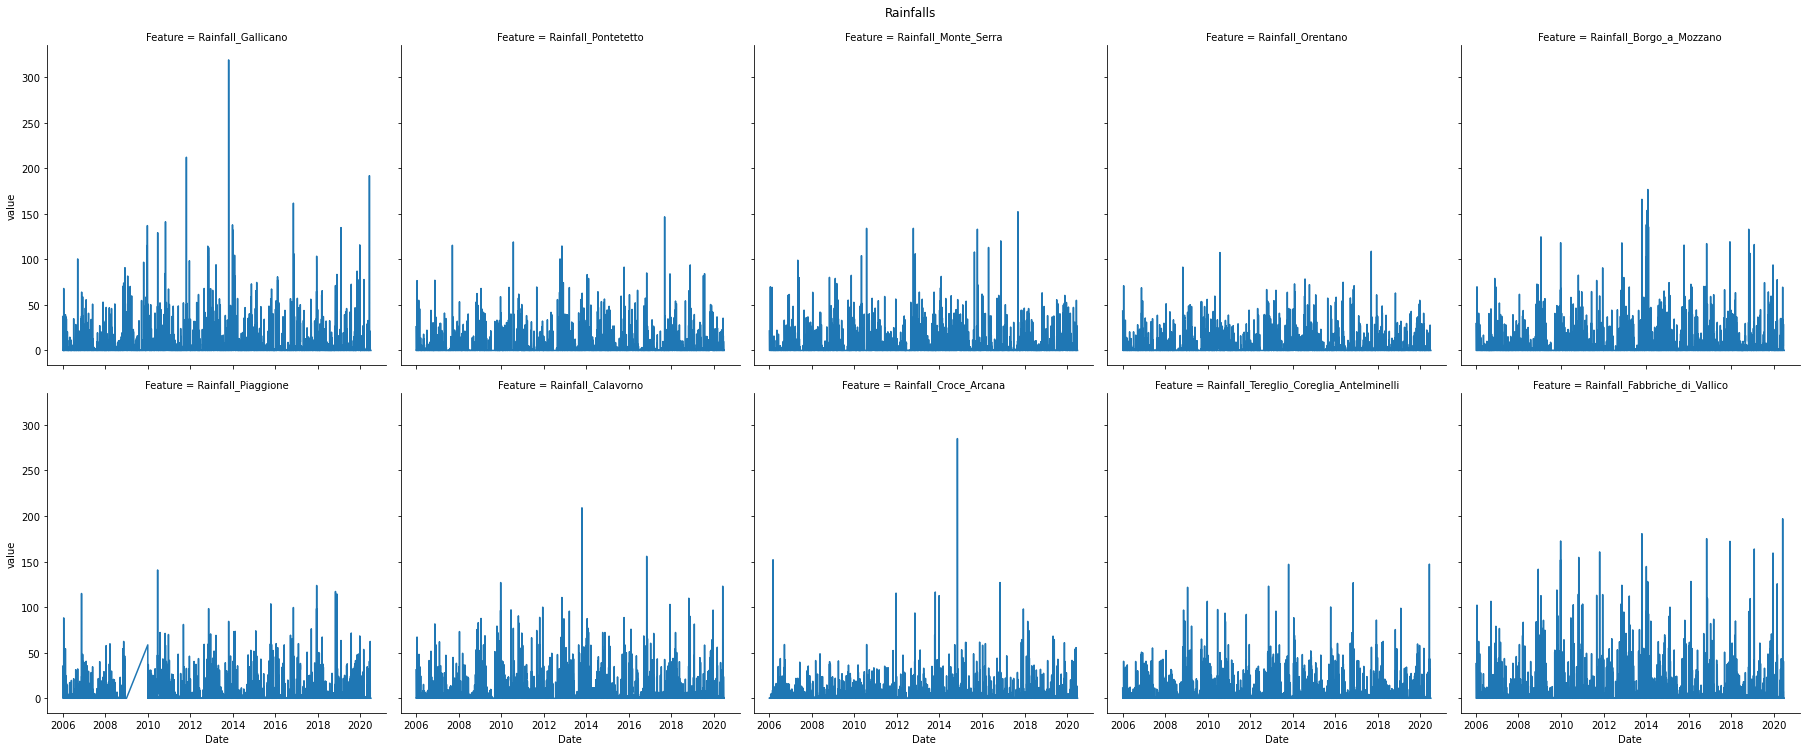

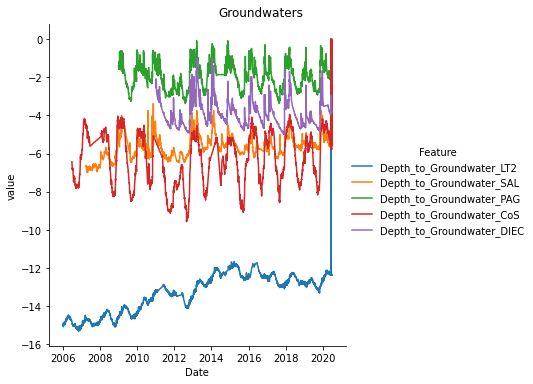

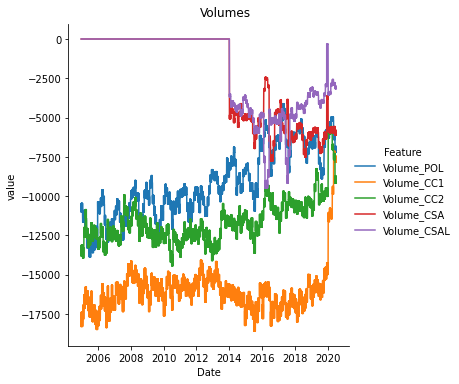

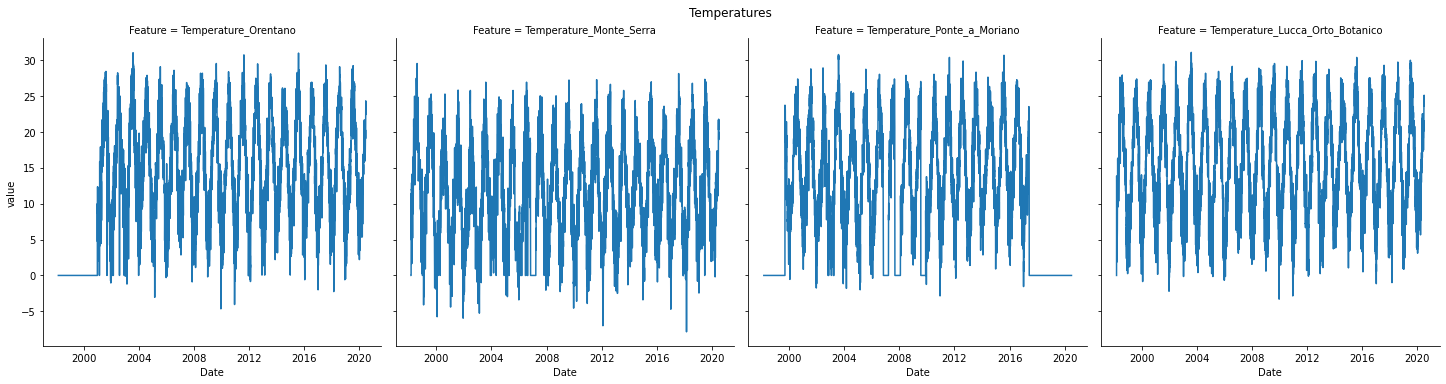

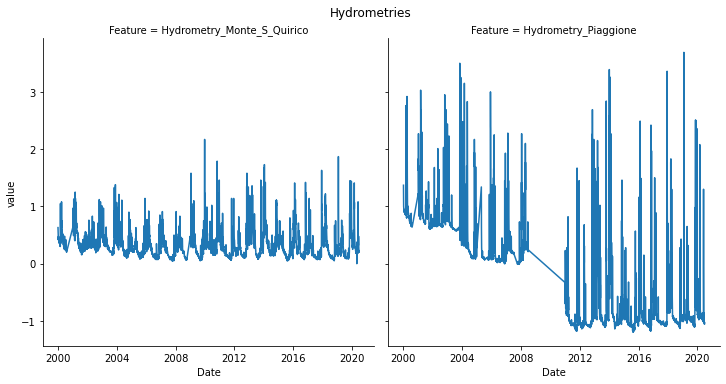

In [11]:
# basic plot of each feature
aquifer_feature_plots(df)

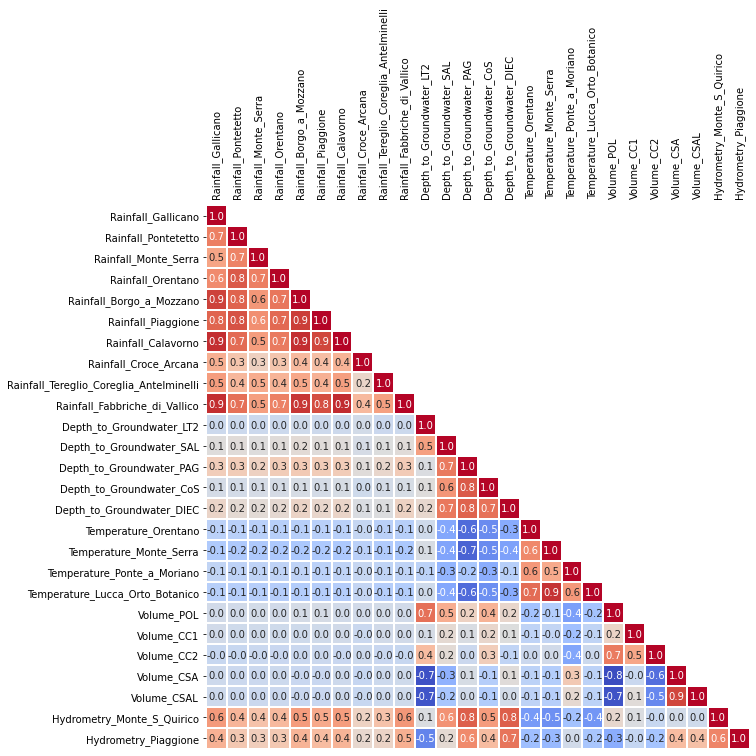

In [12]:
# basic plot of correlation between features
corrtri_plot(df)

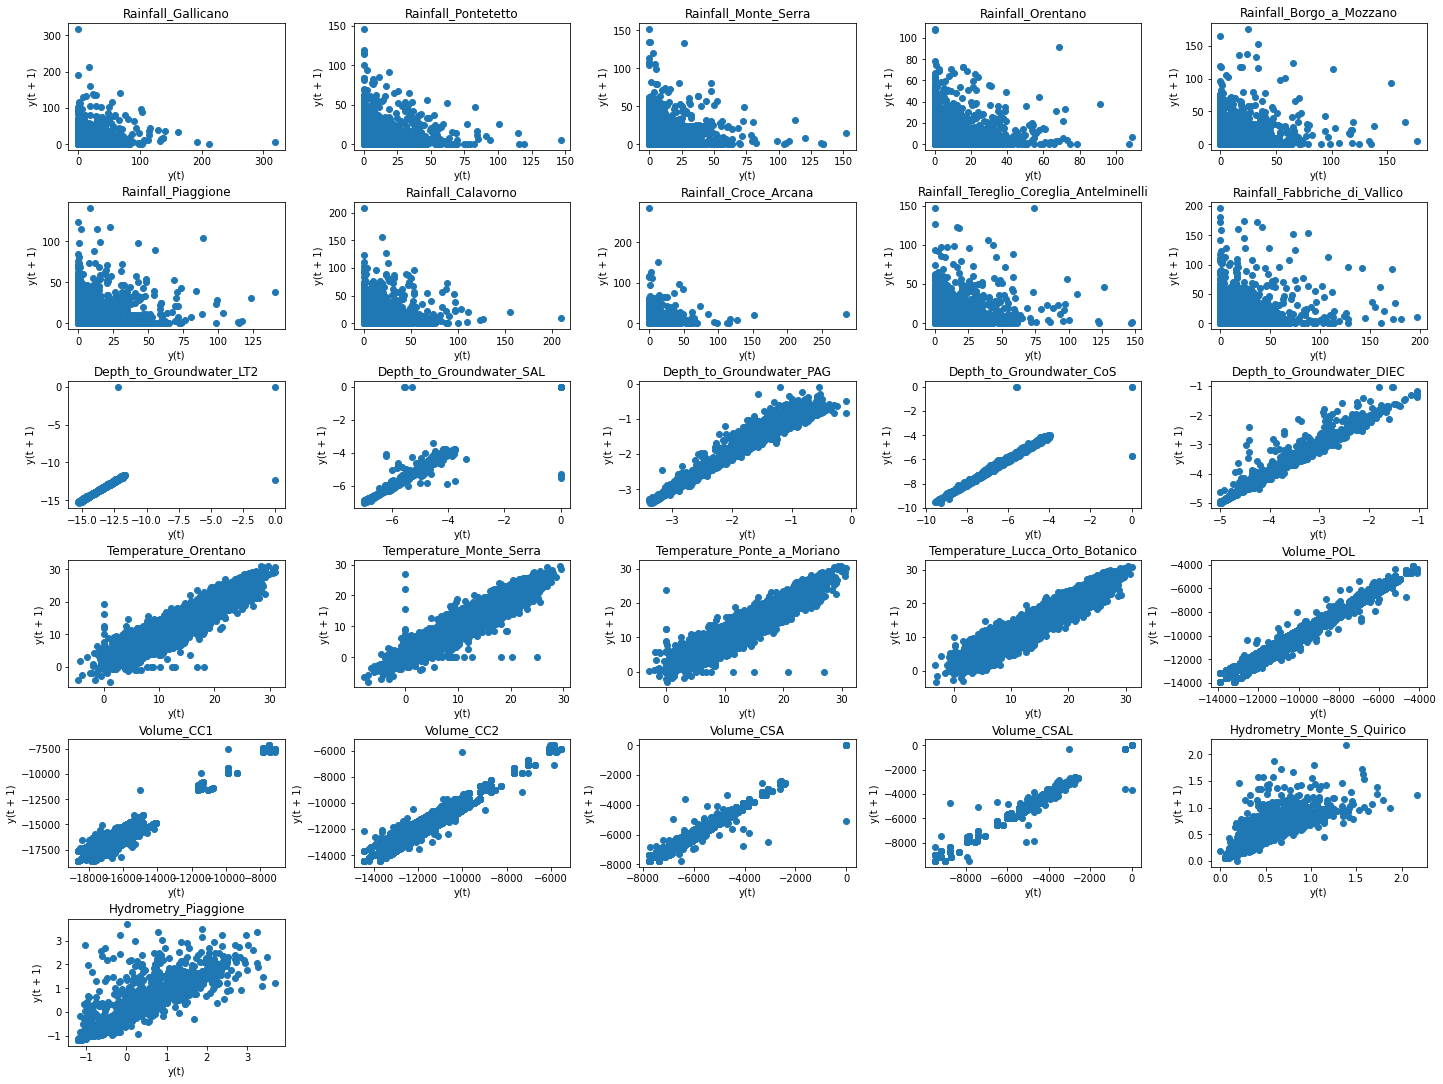

In [13]:
# lag plot
lag_plot(df, lag=1)

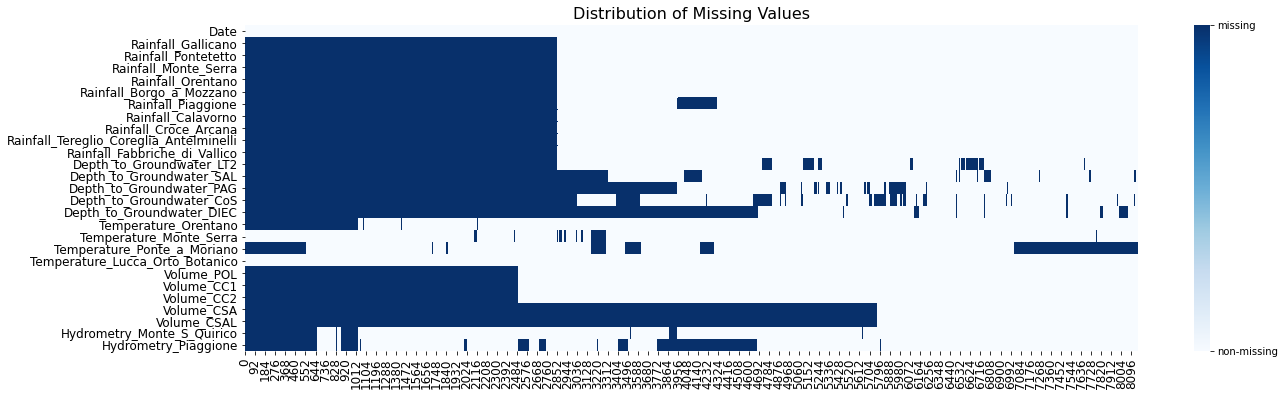

In [14]:
# Set weird values to nan
## set nan to Groundwater whose values are 0
df[df.filter(regex='Depth_*').columns] = df.filter(regex='Depth_*').replace(0, np.nan)
## set nan to Volume whose values are 0
df[df.filter(regex='Volume_*').columns] = df.filter(regex='Volume_*').replace(0, np.nan)
## set nan to Temperature whose values are 0
df[df.filter(regex='Temperature_*').columns] = df.filter(regex='Temperature_*').replace(0, np.nan)

# visual graph of nan locations for each field
missingval_plot(df.reset_index().T.isna())

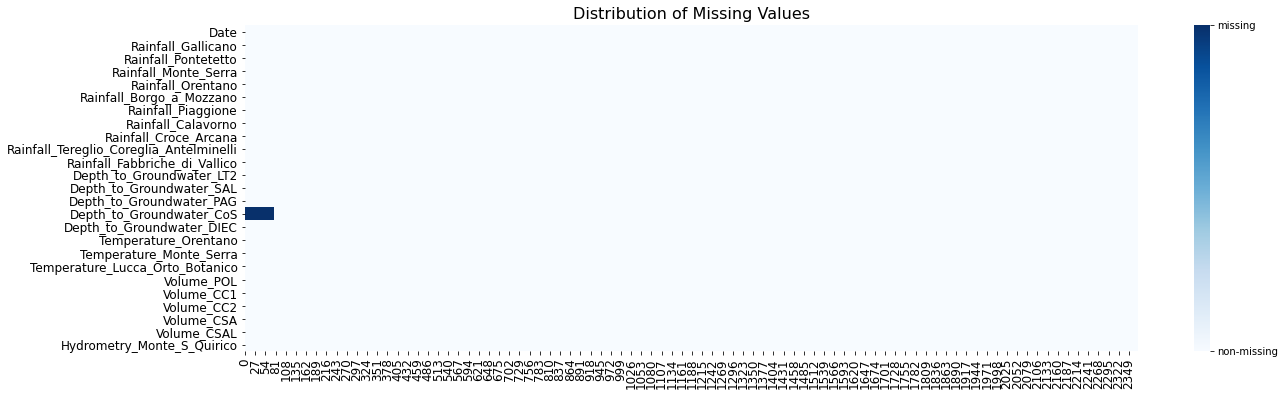

In [15]:
# Dealing with missing values

## drop old/unuseful data
todrop = df[df.Volume_CSA.isna()].index.max()
df = df[df.index > todrop].copy() # remaining data starts from 2014-01-01
## drop columns (to be further confirmed)
df.drop(columns=['Temperature_Ponte_a_Moriano', 'Hydrometry_Piaggione'], inplace=True)

# Record nan positions before imputation
mask = df.isna()

## imputation
#nondate_cols = dfsmall.iloc[:, 2:-9].columns
dfimputed = df.copy()
tmp = fillna(dfimputed, 'interpolate', method='linear').copy()
dfimputed= tmp

## visual graph of nan locations 
missingval_plot(dfimputed.reset_index().T.isna())


In [16]:
todrop = dfimputed[dfimputed['Depth_to_Groundwater_CoS'].isna()].index.max()
dfimputed = dfimputed[dfimputed.index > todrop].copy()
assert dfimputed.isna().any().any() == False

mask = mask[mask.index > todrop].copy()

#aquifer_feature_plots(dfimputed)

In [17]:
# check granger causality
grtable = grangers_causation_table(dfimputed, xnames=dfimputed.columns.drop(labels=targets), 
                          ynames=targets, maxlag=5 ,alpha=0.05)
display(grtable)

,Depth_to_Groundwater_SAL_y,Depth_to_Groundwater_CoS_y,Depth_to_Groundwater_LT2_y
Rainfall_Gallicano_x,True,True,True
Rainfall_Pontetetto_x,True,True,True
Rainfall_Monte_Serra_x,True,True,True
Rainfall_Orentano_x,True,True,True
Rainfall_Borgo_a_Mozzano_x,True,True,True
Rainfall_Piaggione_x,True,True,True
Rainfall_Calavorno_x,True,True,True
Rainfall_Croce_Arcana_x,True,True,True
Rainfall_Tereglio_Coreglia_Antelminelli_x,True,True,True
Rainfall_Fabbriche_di_Vallico_x,True,True,True


In [18]:
# manually drop non Granger-cause variables
dfimputed.drop(columns=['Volume_CC2', 'Volume_CSA', 'Volume_CSAL'], inplace=True)
mask.drop(columns=['Volume_CC2', 'Volume_CSA', 'Volume_CSAL'], inplace=True)

In [19]:
# Chekc stationarity: seasonality can be eliminated by using diff() or deducting a a seasonal pattern found by seasonal_decompose
## adftest
adftable = adfuller_table(dfimputed, verbose=False, alpha=0.05, maxlag=30, regression='ct')
display(adftable)

## collect non-stationary features
I1 = adftable[adftable['AIC_5%level'] == False].index.values

,AIC_5%level,AIC_bestlag,BIC_5%level,BIC_bestlag
Rainfall_Gallicano,True,18,True,0
Rainfall_Pontetetto,True,11,True,0
Rainfall_Monte_Serra,True,13,True,0
Rainfall_Orentano,True,20,True,0
Rainfall_Borgo_a_Mozzano,True,12,True,0
Rainfall_Piaggione,True,12,True,0
Rainfall_Calavorno,True,18,True,2
Rainfall_Croce_Arcana,True,0,True,0
Rainfall_Tereglio_Coreglia_Antelminelli,True,11,True,3
Rainfall_Fabbriche_di_Vallico,True,14,True,2


In [20]:
# cointegration test
tmp = targets.copy()
tmp.extend(x for x in I1 if x not in targets)
cointegration_test(dfimputed[tmp], 0, 12)

 Name   ::  Test Stat > C(95%)    =>   Signif  
 --------------------------------------------------
Depth_to_Groundwater_SAL         :: 420.90  >  159.5290 =>   True
Depth_to_Groundwater_CoS         :: 287.32  >  125.6185 =>   True
Depth_to_Groundwater_LT2         :: 188.41  >   95.7542 =>   True
Temperature_Orentano             :: 113.60  >   69.8189 =>   True
Temperature_Monte_Serra          ::  52.93  >   47.8545 =>   True
Temperature_Lucca_Orto_Botanico  ::  23.26  >   29.7961 =>  False
Volume_POL                       ::   9.76  >   15.4943 =>  False
Volume_CC1                       ::   1.62  >    3.8415 =>  False


In [21]:
# what should we do with results of the coint_J test?

In [22]:
## (Cont'd) diff() on cols that do not pass the adftest. Here we adopt AIC.
dfstationary = dfimputed.copy()
dfstationary.loc[:,I1] = dfstationary[I1].diff()
dfstationary.dropna(inplace=True)

## adftest again
adftable = adfuller_table(dfstationary, verbose=False, maxlag=30, regression='ct')
display(adftable) # This time all features pass ADF test in both AIC and BIC criteria.

,AIC_5%level,AIC_bestlag,BIC_5%level,BIC_bestlag
Rainfall_Gallicano,True,18,True,0
Rainfall_Pontetetto,True,11,True,0
Rainfall_Monte_Serra,True,13,True,0
Rainfall_Orentano,True,20,True,0
Rainfall_Borgo_a_Mozzano,True,12,True,0
Rainfall_Piaggione,True,12,True,0
Rainfall_Calavorno,True,18,True,2
Rainfall_Croce_Arcana,True,0,True,0
Rainfall_Tereglio_Coreglia_Antelminelli,True,11,True,3
Rainfall_Fabbriche_di_Vallico,True,14,True,2


In [23]:
# more feature engineering... to be continued
# Eg, dimension reduction: PCA, LDA; Granger Causality, Cointegration
#     denoicing: FFT/STFT, MovingAvg, 

In [24]:
# deal with Time Periodicity 
## extract year, month, quarter, day etc from Date (to be further confirmed)
# nondate_cols = dfstationary.columns
# dfstationary['year'] = dfstationary.index.year
# dfstationary['month'] = dfstationary.index.month
# dfstationary['day'] = dfstationary.index.day
# dfstationary['day_of_year'] = dfstationary.index.dayofyear
# dfstationary['week_of_year'] = dfstationary.index.isocalendar().week
# dfstationary['quarter'] = dfstationary.index.quarter
# dfstationary['year_quarter'] = dfstationary.index.to_period('q')
## yearly base periodicity
year = 365.2425
dfstationary['year_sin'] = np.sin(dfstationary.index.dayofyear * 2 * np.pi / year)
dfstationary['year_cos'] = np.cos(dfstationary.index.dayofyear * 2 * np.pi / year)
# dfstationary['halfyear_sin'] = np.sin(dfstationary.index.dayofyear * 4 * np.pi / year)
# dfstationary['halfyear_cos'] = np.cos(dfstationary.index.dayofyear * 4 * np.pi / year)

# After all features are included, put target columns at the end
dfstationary = dfstationary.reindex(columns = dfstationary.columns.drop(targets).append(pd.Index(targets)), )

In [25]:
# Splitting data: keep the last ca. 365 data for prediction. Alternative splitting:
N = dfstationary.shape[0]
train, val, test = dfstationary[:int(0.8*N)], dfstationary[int(0.8*N):int(0.9*N)], dfstationary[int(0.9*N):]
_, vmask, tmask = mask[:int(0.8*N)], mask[int(0.8*N):int(0.9*N)], mask[int(0.9*N):]
column_indices = {name: i for i, name in enumerate(train.columns)}

# Scaling and Normalization 
# normalization won't make sense if the TS is trending upward/downward. This is why stationary first.
scaler, train_scaled, val_scaled, test_scaled = scale(train, val, test, approach='MinMax')
print(train_scaled.shape, val_scaled.shape, test_scaled.shape)

(1835, 23) (229, 23) (230, 23)


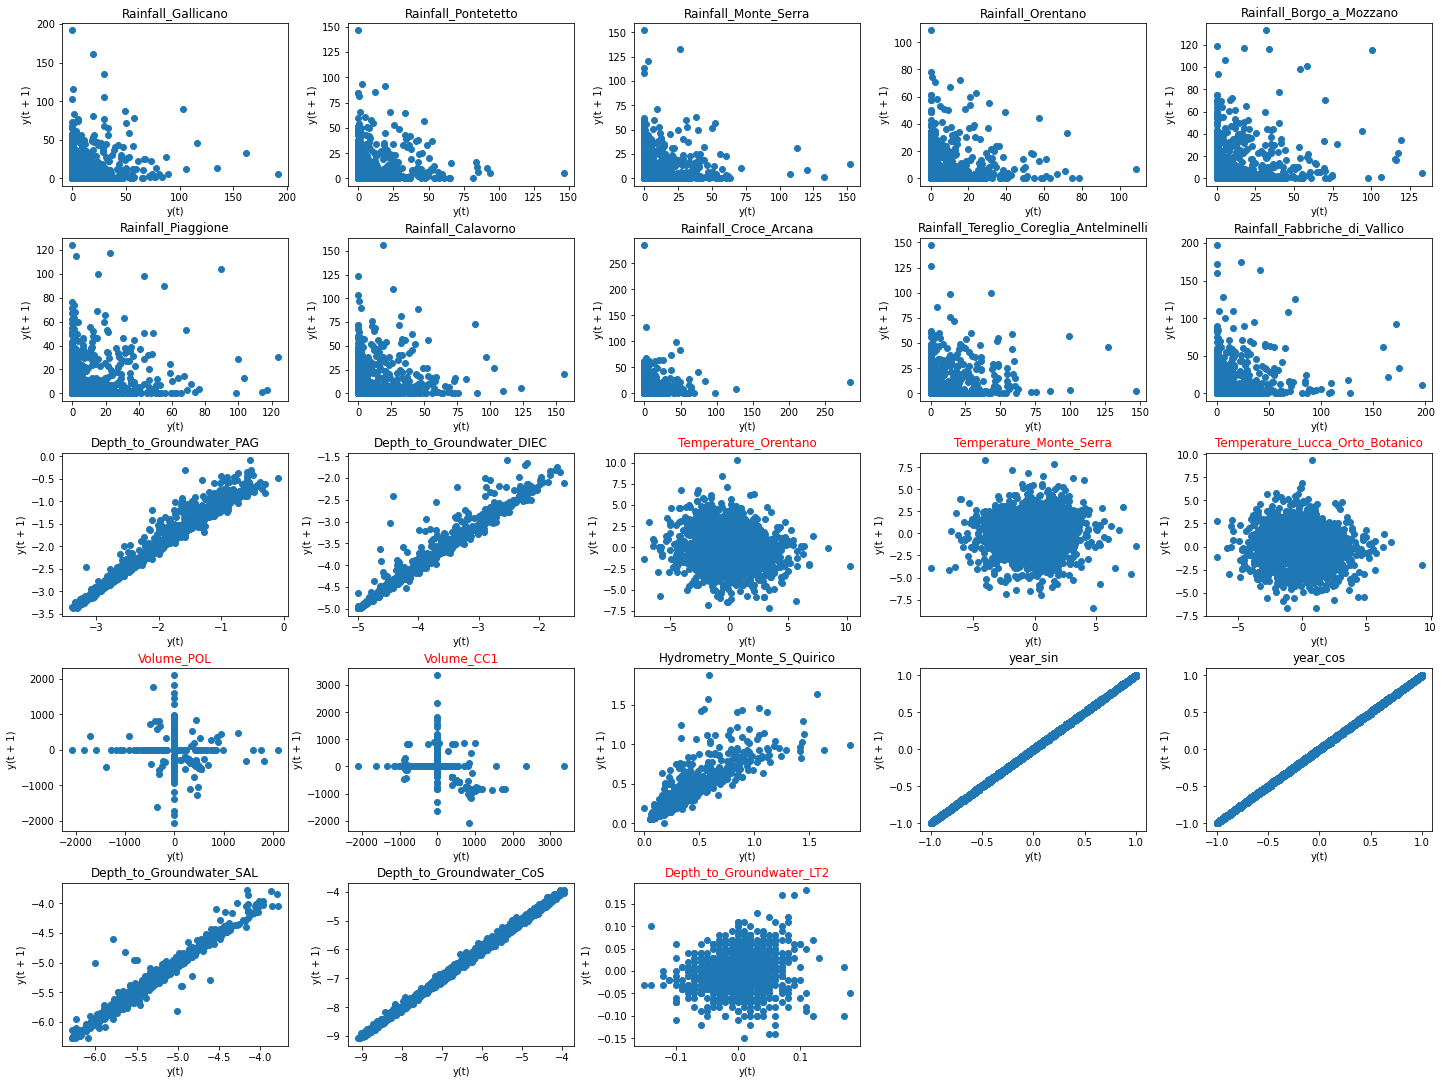

In [26]:
# lag plot
lag_plot(dfstationary, lag=1, redcols=I1)

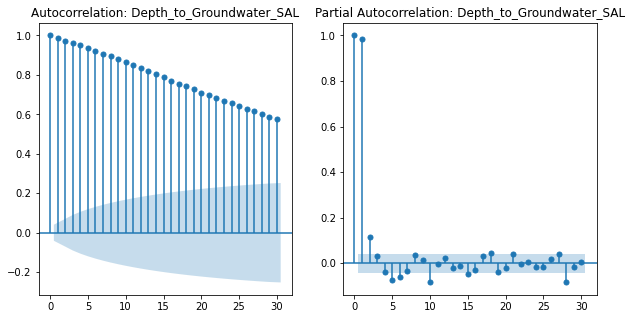

/Users/mbpr/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


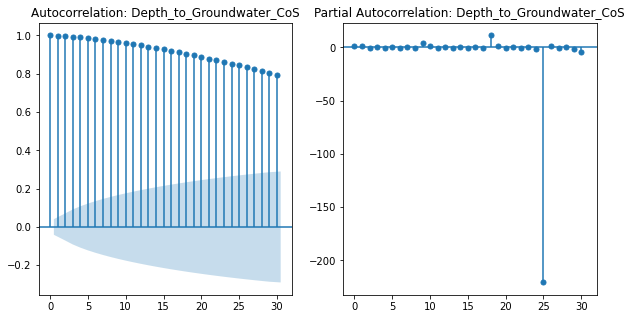

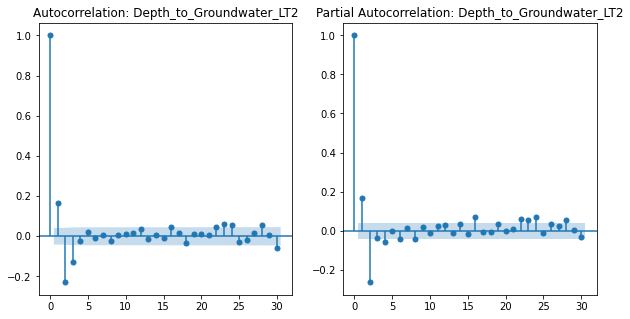

In [27]:
acpac_plot(dfstationary[targets])

In [28]:
# VAR model 
var_model = VAR(endog=train.append(val))
res = var_model.select_order(maxlags=30, trend='ct')
print(res.selected_orders)
varlag = res.selected_orders['aic']
var_model = var_model.fit(varlag)
# put result into self-defined class
varobj = VARresults(var_model, test, mask=tmask[1:] , label_columns=targets)

{'aic': 7, 'bic': 2, 'hqic': 2, 'fpe': 7}


In [29]:
# durbin_watson test for residuals
varobj.durbin_watson_test()
# comment: all values are near 2 => no significant serial correlation in the residual.
# The value of this statistic can vary between 0 and 4. 
# The closer it is to the value 2, then there is no significant serial correlation. 
# The closer to 0, there is a positive serial correlation, 
# and the closer it is to 4 implies negative serial correlation.

Rainfall_Gallicano              :   2.0026
Rainfall_Pontetetto             :   2.0039
Rainfall_Monte_Serra            :   1.9998
Rainfall_Orentano               :   2.0007
Rainfall_Borgo_a_Mozzano        :   2.0009
Rainfall_Piaggione              :   2.0043
Rainfall_Calavorno              :   2.0048
Rainfall_Croce_Arcana           :   2.0035
Rainfall_Tereglio_Coreglia_Antelminelli:   2.0010
Rainfall_Fabbriche_di_Vallico   :   1.9986
Depth_to_Groundwater_PAG        :   2.0082
Depth_to_Groundwater_DIEC       :   1.9959
Temperature_Orentano            :   2.0105
Temperature_Monte_Serra         :   2.0146
Temperature_Lucca_Orto_Botanico :   2.0112
Volume_POL                      :   1.9739
Volume_CC1                      :   1.8546
Hydrometry_Monte_S_Quirico      :   1.9968
year_sin                        :   1.9989
year_cos                        :   1.9988
Depth_to_Groundwater_SAL        :   2.0056
Depth_to_Groundwater_CoS        :   2.0053
Depth_to_Groundwater_LT2        :   1.9915


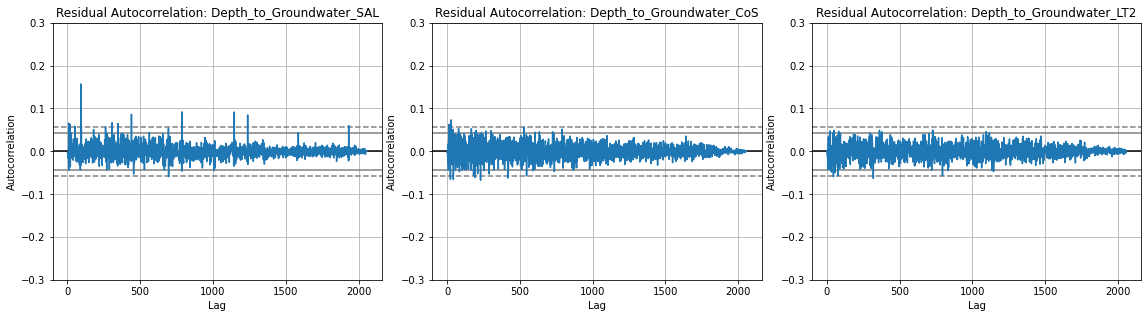

In [30]:
# Residual Autocorrelations
varobj.residac_plot(cols=targets)

In [31]:
# Adjusted Portmannteau Test 
# model size = 7*23*23+7 = 3710
# data size = len(dfstationary) - len(test) = 2064
res = var_model.test_whiteness(nlags=varlag*5, signif=0.05, adjusted=False)
res.summary()

Test statistic,Critical value,p-value,df
1.652e+04,1.510e+04,0.000,14812


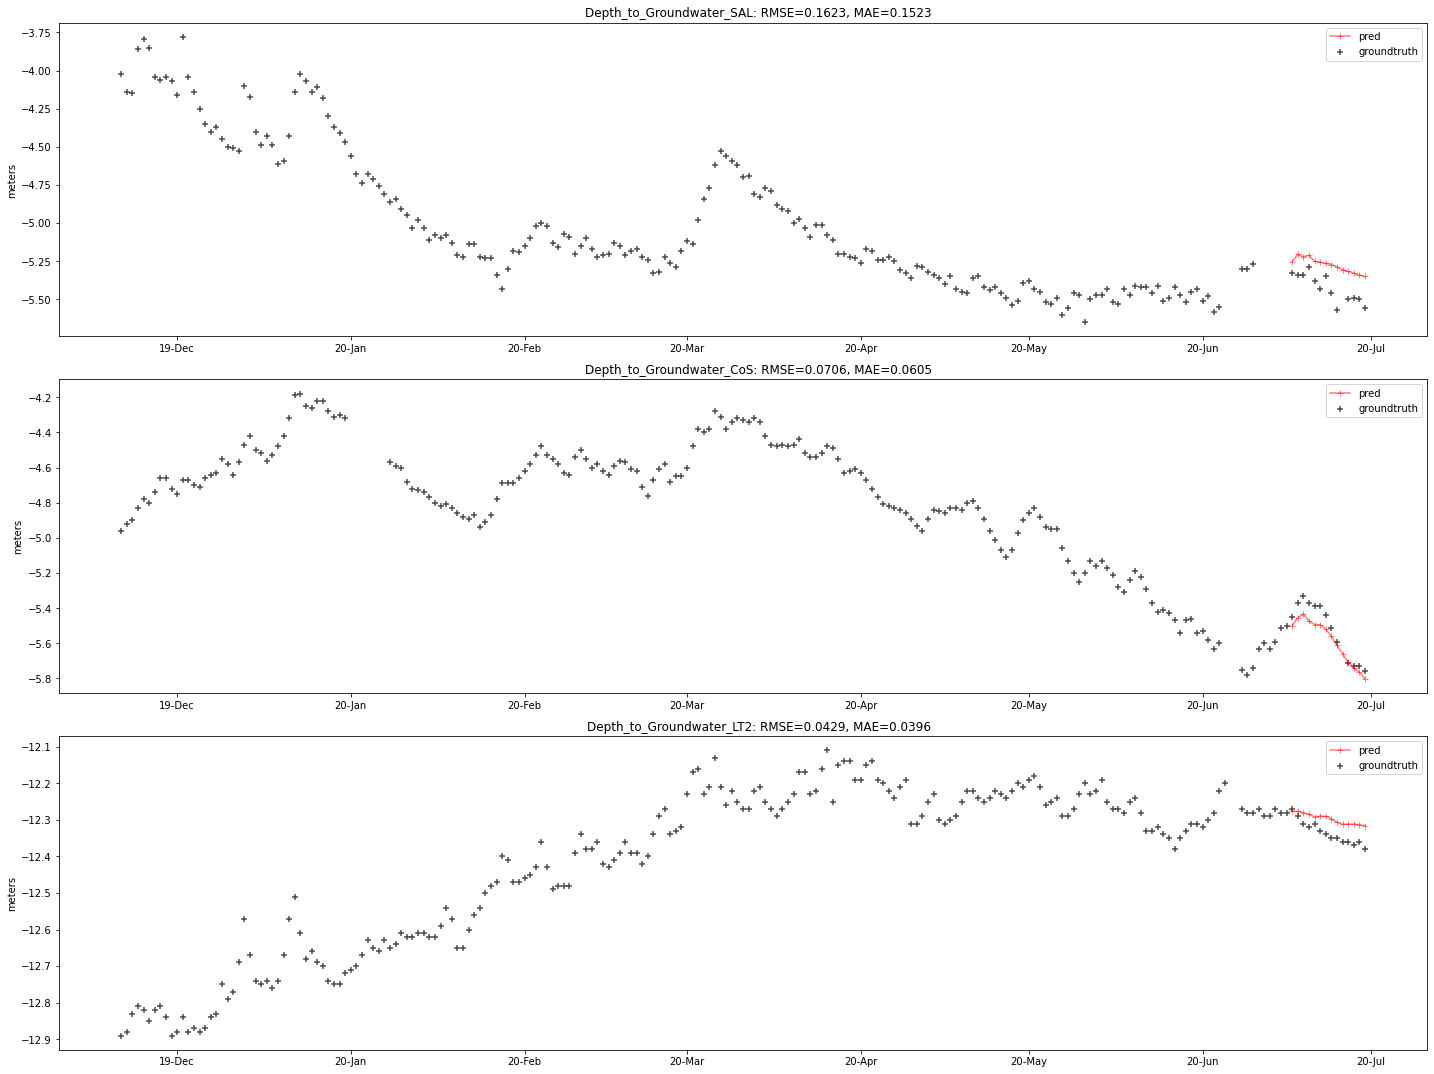

In [32]:
steps=14
mode = 'last' # cannot use mode='normal' if steps > 1 (I'll add this new ability if necessary)
use_mask = True
multioutput = 'raw_values' # calculate rmse/mae for each target feature. 
# (if ='uniform_average', calculate rmse/mea of all target features together and return only one value.)


# method 1:
# varobj.predict(steps=steps, mode=mode, inplace=True)
# varobj.inverse_transform(I1, dfimputed, inplace=True)
# varobj.evaluate(multioutput=multioutput, use_mask=use_mask)

# method 2: equivalent to method 1, where this function inverse_transform_evaluate()
# automatically make inplace=True. I1: records which variables were differenced. 
# dfimputed: helps back-transform the pred & gt. 
# use_mask: Only affects evaluation() and plot(). 
#           if =True, then calculate rmse/mae only on those elements that is not masked/missing initially.
#                     and leave blank spaces in groundtruth when plotting.
#           if =False, calculate rmse/mae on all elements, and plot groundtruth including imputed values.
varobj.inverse_transform_evaluate(I1, dfimputed, steps=steps, mode=mode, 
                                  multioutput=multioutput, use_mask=use_mask)

# draw
varobj.plot(use_mask=True)

### Auser- Fitting into LSTM

In [42]:
# define windows and parameters
batch_size=1
n_features = train_scaled.shape[1]
n_out = len(targets)

## single window (ie, n-to-1/1-to-1) with single output
window = WindowGenerator(input_width=7, label_width=1, shift=1, label_columns=targets, 
    batch_size=batch_size, train_df=train_scaled, val_df=val_scaled, test_df=test_scaled, shuffle=False)
print(window)
print('Inputs/labels shapes of window: {} {}'.format(
    window.example[0].shape, window.example[1].shape))


## single window with multi output
wide_window = WindowGenerator(input_width=7, label_width=7, shift=1, label_columns=targets, 
    batch_size=batch_size, train_df=train_scaled, val_df=val_scaled, test_df=test_scaled, shuffle=False)
print('\n', wide_window)
print('Inputs/labels shapes of wide_window: {} {}'.format(
    wide_window.example[0].shape, wide_window.example[1].shape))

## collector initialization
val_performance = {}
performance = {}
val_unscaled_perf = {}
unscaled_perf = {}

Total window size: 8
Input indices: [0 1 2 3 4 5 6]
Label indices: [7]
Label column name(s): ['Depth_to_Groundwater_SAL', 'Depth_to_Groundwater_CoS', 'Depth_to_Groundwater_LT2']
Inputs/labels shapes of window: (1, 7, 23) (1, 1, 3)

 Total window size: 8
Input indices: [0 1 2 3 4 5 6]
Label indices: [1 2 3 4 5 6 7]
Label column name(s): ['Depth_to_Groundwater_SAL', 'Depth_to_Groundwater_CoS', 'Depth_to_Groundwater_LT2']
Inputs/labels shapes of wide_window: (1, 7, 23) (1, 7, 3)


window baseline
Xtrain shape:  (1, 7, 23) ytrain shape:  (1, 1, 3)
output shape:  (1, 1, 3)
222/222 - 0s - loss: 0.0202 - mean_absolute_error: 0.0762 - mean_squared_error: 0.0202
223/223 - 0s - loss: 0.0350 - mean_absolute_error: 0.0978 - mean_squared_error: 0.0350


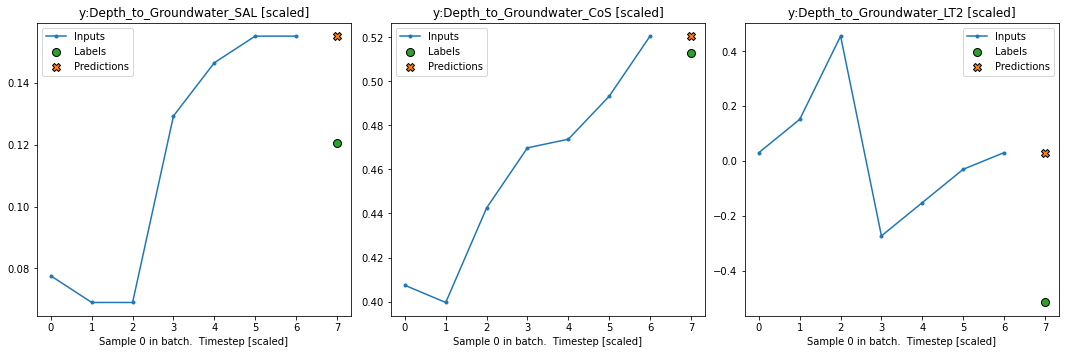

In [43]:
# Single-step naive baseline prediction: y(t+1) = y(t)
## single-output
baseline = Baseline(label_index=[column_indices[ta] for ta in targets])
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError(), tf.metrics.MeanSquaredError()])

print('window baseline')
print('Xtrain shape: ', window.example[0].shape, 'ytrain shape: ', window.example[1].shape)
print('output shape: ', baseline(window.example[0]).shape)


val_performance['Baseline_singleout'] = baseline.evaluate(window.val, verbose=2, return_dict=True)
performance['Baseline_singleout'] = baseline.evaluate(window.test, verbose=2, return_dict=True) 
window.plot(targets, baseline, figsize=(15,5))

val_unscaled_perf['Baseline_singleout'] = window.inverse_transform_evaluate(scaler, 
                                                baseline, I1, dfimputed, mode='val', return_dict=True)
unscaled_perf['Baseline_singleout'] =  window.inverse_transform_evaluate(scaler, 
                                                baseline, I1, dfimputed, mode='test', return_dict=True)


window RNN
Xtrain shape:  (1, 7, 23) ytrain shape:  (1, 1, 3)
output shape:  (1, 1, 3)
Epoch 1/30
1828/1828 - 7s - loss: 0.0191 - mean_absolute_error: 0.0922 - mean_squared_error: 0.0191 - val_loss: 0.0558 - val_mean_absolute_error: 0.1823 - val_mean_squared_error: 0.0558
Epoch 2/30
1828/1828 - 5s - loss: 0.0151 - mean_absolute_error: 0.0794 - mean_squared_error: 0.0151 - val_loss: 0.0516 - val_mean_absolute_error: 0.1681 - val_mean_squared_error: 0.0516
Epoch 3/30
1828/1828 - 4s - loss: 0.0144 - mean_absolute_error: 0.0780 - mean_squared_error: 0.0144 - val_loss: 0.0442 - val_mean_absolute_error: 0.1565 - val_mean_squared_error: 0.0442
Epoch 4/30
1828/1828 - 4s - loss: 0.0135 - mean_absolute_error: 0.0741 - mean_squared_error: 0.0135 - val_loss: 0.0356 - val_mean_absolute_error: 0.1364 - val_mean_squared_error: 0.0356
Epoch 5/30
1828/1828 - 4s - loss: 0.0126 - mean_absolute_error: 0.0711 - mean_squared_error: 0.0126 - val_loss: 0.0283 - val_mean_absolute_error: 0.1221 - val_mean_squar

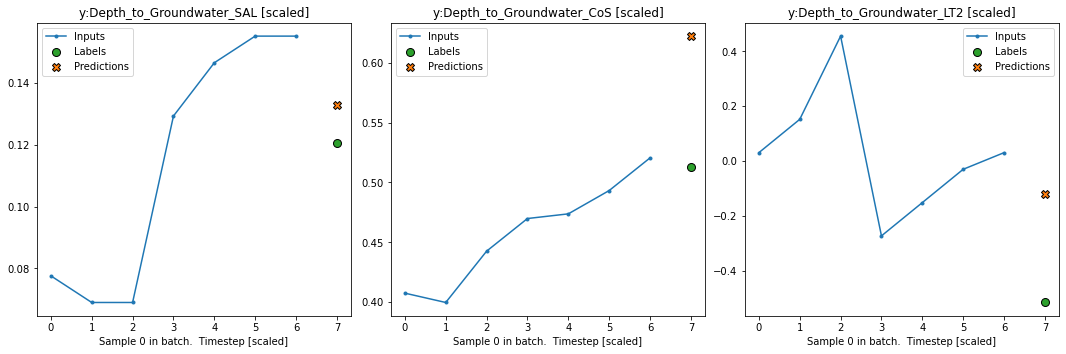

In [44]:
# Single-step RNN
## single-output
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(16, return_sequences=False),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=3), 
    tf.keras.layers.Reshape([1, -1])
])
MAX_EPOCHS = 30

print('window RNN')
print('Xtrain shape: ', window.example[0].shape, 'ytrain shape: ', window.example[1].shape)
print('output shape: ', lstm_model(window.example[0]).shape)


history = compile_and_fit(lstm_model, window, MAX_EPOCHS)

val_performance['lstm_singleout'] = lstm_model.evaluate(window.val, verbose=2, return_dict=True)
performance['lstm_singleout'] = lstm_model.evaluate(window.test, verbose=2, return_dict=True)
window.plot(targets, lstm_model, figsize=(15,5))

val_unscaled_perf['lstm_singleout'] = window.inverse_transform_evaluate(scaler, 
                                            lstm_model, I1, dfimputed, mode='val', return_dict=True)
unscaled_perf['lstm_singleout'] = window.inverse_transform_evaluate(scaler, 
                                            lstm_model, I1, dfimputed, mode='test', return_dict=True)

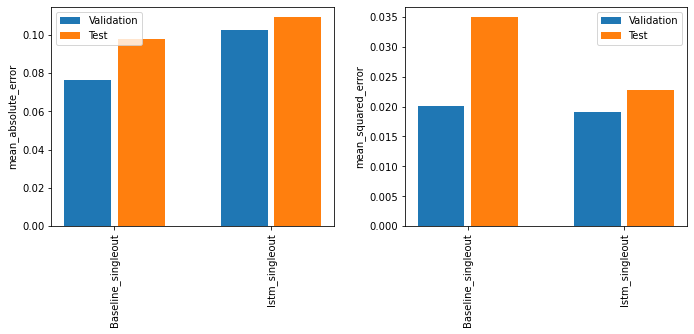

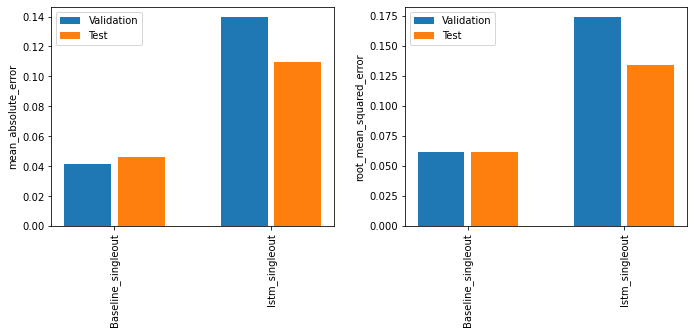

In [45]:
# conclude single step model performance
metrics_plot(val_performance, performance, ['mean_absolute_error', 'mean_squared_error'])
metrics_plot(val_unscaled_perf, unscaled_perf, ['mean_absolute_error', 'root_mean_squared_error'])

# References

* [Understanding LSTM Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)
* [Cross-batch statefulness- Working with RNNs](https://keras.io/guides/working_with_rnns/)
* [Time Series Forecasting, Tensorflow](https://www.tensorflow.org/tutorials/structured_data/time_series#top_of_page)
* [Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)
* [Multivariate Time Series Forecasting with LSTMs in Keras](https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/)
* [(About LSTM Rolling-Predictions) How to Update LSTM Networks During Training for Time Series Forecasting](https://machinelearningmastery.com/update-lstm-networks-training-time-series-forecasting/)
* [How to use Different Batch Sizes when Training and Predicting with LSTMs](https://machinelearningmastery.com/use-different-batch-sizes-training-predicting-python-keras/)
* [Combine LSTM and VAR for Multivariate Time Series Forecasting](https://towardsdatascience.com/combine-lstm-and-var-for-multivariate-time-series-forecasting-abdcb3c7939b)
* [Not yet Read](https://machinelearningmastery.com/suitability-long-short-term-memory-networks-time-series-forecasting/)
* [How to Build VAR model](https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/)